In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, load_checkpoint
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.ot_utils import FGW 
from mol_opt.ot_utils import compute_barycenter

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty
from molgen.metrics.mol_metrics import MolMetrics

from rdkit.Chem import MolFromSmiles
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from molgen.metrics.Penalty import Penalty as PenaltyNew

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

/home/octav/gitrepos/tum-thesis


In [2]:
model_type = "pointwise"
sys.argv = ["", "-cuda", "-model_type", model_type, "-one_batch_train"]
args = get_args()
outdir_suffix = "dev2"
args.n_epochs = 100 
# args.init_model = "{}-test13-valconeul-dynamic-softmax1".format(model_type)
args.init_model = "{}-base-longer-softmax3".format(model_type)
# args.init_model = "{}-test12-valconeul-dynamic-tau1-softmax5".format(model_type)
args.init_decoder_model = "{}_decode".format(args.init_model)
args.output_dir = "mol_opt/output_{}/{}/".format(outdir_suffix, args.init_model)
args.tb_logs_dir = "mol_opt/logs_{}/{}/".format(outdir_suffix, args.init_model)
args.batch_size = 50 

In [3]:
model = args.init_model
model_iter = 14500 

model_name = "model_{}_{}".format(model, model_iter)
print(args.output_dir + model_name)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)

molopt, molopt_decoder, _, pen, _, config, _ = load_checkpoint(args.output_dir + model_name)

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False)
fgw_loss = FGW(alpha = 0.5)
# pen = PenaltyNew(config, model_iter)

molopt_module_list = torch.nn.ModuleList([molopt, molopt_decoder])

# molopt = MolOpt(args)
# molopt_decoder = MolOptDecoder(args)
print (molopt)
print (molopt_decoder)
print(molopt.args.model_type)
pen.log()

mol_opt/output_dev2/pointwise-base-longer-softmax3/model_pointwise-base-longer-softmax3_14500
MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=300, bias=False)
    (W_message_h): Linear(in_features=300, out_features=300, bias=False)
    (W_message_o): Linear(in_features=393, out_features=100, bias=True)
    (W_mol_h): Linear(in_features=100, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (opt0): Linear(in_features=100, out_features=300, bias=True)
  (opt1): Linear(in_features=300, out_features=100, bias=True)
)
MolOptDecoder(
  (fc1_SYMBOLS): Linear(in_features=100, out_features=150, bias=True)
  (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
  (fc1_CHARGES): Linear(in_features=100, out_features=150, bias=True)
  (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
  (fc1_BON

In [4]:
# train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train_pairs", args.batch_size, True)
train_data_loader = get_loader("molgen/data/chembl50", "train", 50, same_number_atoms = True)

for i in train_data_loader:
#     X = (MolGraph(i[0]))
#     Y = (MolGraph(i[1]))
    X = MolGraph(i)
    Y = X
    break

In [5]:
x_embedding = molopt.forward(X)
yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
# yhat_labels = molopt_decoder.discretize_gumbel(*yhat_logits, tau = pen.tau)
pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

target = Y.get_graph_outputs()
symbols_labels, charges_labels, bonds_labels = yhat_labels
symbols_logits, charges_logits, bonds_logits = yhat_logits

pen.mirror = ""

pen.tau = 0.05
fgw_loss_item = fgw_loss(*pred_pack, tau = 1)
print (fgw_loss_item.item()/args.batch_size)
pen_loss = pen(*pred_pack, model_iter)
print (pen_loss)
metrics.measure_batch(pred_pack[0], target)

/home/octav/gitrepos/tum-thesis/otgnn/models/gromov_modules.py:394: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nce_reg = torch.nn.LogSoftmax()(torch.stack(all_nce_dists))[0]


FGW torch.Size([29508, 5]) 0.00013588249566964805
0.9710801696777344
(tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))


({'batch_molecular_validity': 84.0,
  'batch_correctness': 0.0,
  'batch_symbol_accuracy': 89.65217391304348,
  'batch_molecular_disconnected_validity': 92.0,
  'batch_connected_components': 1.26,
  'batch_invalid_valency_nodes': 0.43478260869565216,
  'batch_nodes_0degree': 0,
  'batch_nodes_7plus_degree': 0,
  'invalid_euler_toofew': 0.0,
  'invalid_euler_toomany': 2.0},
 {'avg_euler_error': (3.180000000000001, 50, 1.8276000000000008),
  'batch_node_degree': (2.28, 1150, 0.9372521739130434)})

In [6]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# cap_value = 1e-02
# 
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod, eigenvectors=True)[0] # IMPORTANT: need to compute eigenvectors for autograd
# capped = torch.clamp(eigenvals, min=1e-6, max=1e-02)
# print (eigenvals)
# -torch.sum(torch.log(capped)) + len(eigenvals) * np.log(cap_value)

In [7]:
print([x.item() / args.batch_size for x in pen_loss])
print(bonds_labels.unique(return_counts = True))

[0.0, 0.0, 0.0]
(tensor([0, 2, 4], device='cuda:0'), tensor([ 2616,     2, 26890], device='cuda:0'))


In [8]:
target_bond_counts = torch.zeros(len(BOND_TYPES))
for i in range(len(target)):
    target_bond_counts += target[i]["BOND_TYPES"].sum(axis = (0,1))
print(target_bond_counts.int())

tensor([ 1768,   716,     4,     0, 27020], dtype=torch.int32)


In [9]:
bonds_logits

tensor([[-1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  1.0000e+03],
        [ 8.6680e-01, -5.6925e+00, -1.3328e+01, -3.8656e+01,  4.9202e-01],
        [-5.4428e-01, -1.3959e+01, -2.4234e+01, -6.2375e+01,  3.7562e+00],
        ...,
        [-4.2983e+00, -1.5328e+01, -4.2066e+01, -8.1599e+01,  6.9524e+00],
        [ 3.1299e-01, -2.2216e+00, -5.6623e+00, -1.5855e+01,  1.0342e-01],
        [-1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  1.0000e+03]],
       device='cuda:0', grad_fn=<CatBackward>)

In [10]:
G_fgw = grad(fgw_loss_item, x_embedding, retain_graph = True)
G_euler = grad(pen_loss[2], bonds_logits, retain_graph = True)

print(G_euler[0].abs().mean().item())
print(G_fgw[0].abs().mean().item())
print()
print(np.mean((torch.sum(G_euler[0], dim = 1) == 0).cpu().detach().numpy()))
print(np.mean((torch.sum(G_fgw[0], dim = 1) == 0).cpu().detach().numpy()))
print()
print(symbols_logits.abs().mean().item())
print(bonds_logits.abs().mean().item())

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [11]:
bonds_logits_softmaxed = nn.Softmax(dim = 1)(bonds_logits)

In [12]:
grad(bonds_logits_softmaxed[:,4].sum(), bonds_logits, retain_graph = True)[0].sum()

tensor(-6.5029e-05, device='cuda:0')

In [13]:
bonds_logits_softmaxed

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [5.9212e-01, 8.3891e-04, 4.0517e-07, 4.0550e-18, 4.0704e-01],
        [1.3381e-02, 1.9984e-08, 6.8865e-13, 1.8788e-29, 9.8662e-01],
        ...,
        [1.2997e-05, 2.1072e-10, 5.1483e-22, 3.4897e-39, 9.9999e-01],
        [5.2833e-01, 4.1892e-02, 1.3423e-03, 5.0275e-08, 4.2844e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [14]:
x_embedding.shape

torch.Size([1150, 100])

In [15]:
bond_idx = 0
smiles = []

yhat = []
yact = []
for mol_idx, (st, le) in enumerate(Y.scope):
    symbols = symbols_labels[st:st+le]
    charges = charges_labels[st:st+le]
    bonds = bonds_labels[bond_idx:bond_idx+le*le].view(le, le)
    bond_idx += le * le
    smiles.append(feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False))
    yhat.append(le)
    yact.append((bonds != 4).sum().item()/2.)
    print (mol_idx, yact[-1], le)
    print (smiles[-1])
    
yhat = np.array(yhat)
yact = np.array(yact)


0 30.0 25
CC1C(CCCCCCC(N)CC2CCC2)C1CCC12C3C4C1C3C42
1 18.0 16
CC1CC1CC12CC(N1)C2CCC(C)(C)O
2 30.0 29
CC(C)(C)C.CC(C)C.CN(C)CNCC1CCC1C1(CC2(N)CCC2)C2CC21
3 40.0 35
CCC1C(C)C2CC3(C)CC4(C(CC(C)(C)CCN5C6NC5N6)CC234)C1C(C)CCCCC(C)N
4 23.0 21
CNC(N)(CCC1(C)C2C3C(N(C)C)C2C31)NC(N)(N)N
5 50.0 47
CC.CC(C)CC1(CC(C)(CC(C)C(C)C)C(CCC(N)NCN(C)C)(CCC(C)(C)(C)O)C2C3C(C45CN(C4)C5)C2C3(C)N)CC1
6 21.0 18
CCC1(CCCC(C)C)C2C1N2C1CC2(C)NC12
7 26.0 23
CC(C)C1C2C3CC(C(NCN)NC(N)N)C4CC(C)(C)C42C31
8 27.0 23
CC1CC2(CC3CCCNC3)CC3(C2)CC13CC1CC(C)(C)C1
9 20.0 18
CC1CC(C)(OCCC2NCC23CN(CN)C3)C1
10 20.0 16
N[SH](N)NCC12CC3(CC45CC(C4)C5)C1C23
11 28.0 23
CC(C)(C)C12CC(C3CC(C4C(C5NN5)CC45CCC5)C3)(C1)C2
12 21.0 18
CC12CCC(C3CC3C3CCC3)NCCC1NC2
13 24.0 21
CCNC(C)C1(C(C)C(C)CC)CC2(C1)C1CC12C1CC1
14 8.0 7
C#CC12CC1(C)O2
15 15.0 12
CC1C(C2CC2)CC12CN1NC12
16 16.0 12
CCC12C3C(N4N5NN54)C1(S)C32
17 24.0 21
CC1NCC(C2C34CC2(C3)C4(C)C)C(C)(C)[SH]1C(N)(N)N
18 20.0 17
CCCC1(C)CC2(C(C)CN)CC3C4C3C4C12
19 26.0 23
CC(CCCCC1C2CC1C2NC1(C)CCC

(array([ 1.,  6.,  5.,  0., 19., 11.,  0.,  7.,  0.,  1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

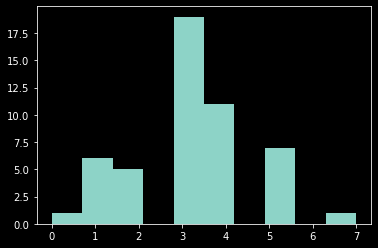

In [16]:
plt.hist(yact - yhat)

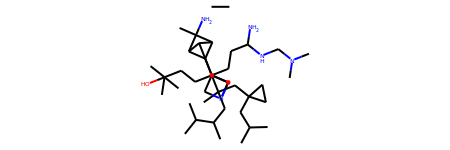

In [17]:
Chem.MolFromSmiles(smiles[5], sanitize = False)

In [18]:
np.arange(0,1000,100)

array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [19]:
mol_idx = 0 
torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
        2])

In [20]:
(x_embedding.mean(axis = 0) / x_embedding.std(axis = 0)).abs().max()

tensor(1.9771, device='cuda:0', grad_fn=<MaxBackward1>)

In [21]:
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]
initial_smiles = [Chem.MolToSmiles(y) for y in X.rd_mols]

# uncomment for tensorboard
tb_writer = SummaryWriter(logdir = args.tb_logs_dir)
mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)
mol_drawer.visualize_batch(pred_pack[0], target_smiles, model_iter, initial_smiles, text="{}-{}-manual-".format(args.init_model, model_iter))

CC1C(CCCCCCC(N)CC2CCC2)C1CCC12C3C4C1C3C42
CC1CC1CC12CC(N1)C2CCC(C)(C)O
CC(C)(C)C.CC(C)C.CN(C)CNCC1CCC1C1(CC2(N)CCC2)C2CC21
CCC1C(C)C2CC3(C)CC4(C(CC(C)(C)CCN5C6NC5N6)CC234)C1C(C)CCCCC(C)N
CNC(N)(CCC1(C)C2C3C(N(C)C)C2C31)NC(N)(N)N
CC.CC(C)CC1(CC(C)(CC(C)C(C)C)C(CCC(N)NCN(C)C)(CCC(C)(C)(C)O)C2C3C(C45CN(C4)C5)C2C3(C)N)CC1
CCC1(CCCC(C)C)C2C1N2C1CC2(C)NC12
CC(C)C1C2C3CC(C(NCN)NC(N)N)C4CC(C)(C)C42C31
CC1CC2(CC3CCCNC3)CC3(C2)CC13CC1CC(C)(C)C1
CC1CC(C)(OCCC2NCC23CN(CN)C3)C1
N[SH](N)NCC12CC3(CC45CC(C4)C5)C1C23
CC(C)(C)C12CC(C3CC(C4C(C5NN5)CC45CCC5)C3)(C1)C2
CC12CCC(C3CC3C3CCC3)NCCC1NC2
CCNC(C)C1(C(C)C(C)CC)CC2(C1)C1CC12C1CC1
C#CC12CC1(C)O2
CC1C(C2CC2)CC12CN1NC12
CCC12C3C(N4N5NN54)C1(S)C32
CC1NCC(C2C34CC2(C3)C4(C)C)C(C)(C)[SH]1C(N)(N)N
CCCC1(C)CC2(C(C)CN)CC3C4C3C4C12
CC(CCCCC1C2CC1C2NC1(C)CCC1)C1CC(NN)C1
CNCCC1C2C3(N)BrC4(CCC(C)C)CC45CC(N5)C(C)C2(C)N13
CCSC1(NC(C)(N)C(C)C)CC(C(C)CC2CC3(C2)CC2C4CC23N4)C1
CCCNC(C)(N)NC1(NC(C)(F)CCC(C)C2CC23CC3)C2C34CC2(C13)C4(C)C
CCC1C(CCCC2CCC2)CC(C)CN2C(C)C3(C4CC

In [27]:
feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False)

'C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.O.O.O.O'

In [67]:
tau = pen.tau
# tau = 0.001
# symbols_nll, charges_nll, bonds_nll = F.gumbel_softmax(tau = tau, dim=1, logits = symbols_logits), F.gumbel_softmax(tau=tau,dim=1,logits=charges_logits), F.gumbel_softmax(tau=tau,dim=1, logits = bonds_logits)
# symbols_nll, charges_nll, bonds_nll = -nn.LogSoftmax(dim=1)(symbols_logits/tau),\
#              -nn.LogSoftmax(dim=1)(charges_logits/tau), -nn.LogSoftmax(dim=1)(bonds_logits/tau)

def softmax(logits, tau):
#     logitsn = F.normalize(logits, dim = 1)
#     return -nn.LogSoftmax(dim=1)(logitsn/tau)
    return F.gumbel_softmax(tau = tau, dim=1, logits = logits)

symbols_nll = softmax(symbols_logits, tau)
charges_nll = softmax(charges_logits, tau)
bonds_nll = softmax(bonds_logits, tau)

In [68]:
pen.tau

0.05195383849590577

(array([201., 231., 302., 166., 129.,  31.,  15.,   3.,   0.,   1.]),
 array([ 47.78911,  64.59665,  81.40419,  98.21173, 115.01927, 131.82681,
        148.63435, 165.4419 , 182.24944, 199.05698, 215.86452],
       dtype=float32),
 <a list of 10 Patch objects>)

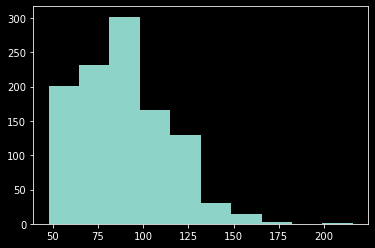

In [39]:
plt.hist(symbols_logits.norm(dim = 1).cpu().detach().numpy())

(array([  24.,   19.,   36.,   26.,   17.,   32.,   31.,   21.,   36.,
          33.,   37.,   35.,   64.,   66.,   97.,   71.,   65.,   86.,
          72.,   75.,  106.,   87.,   79.,   95.,   68.,   72.,   76.,
          61.,   81.,   70.,   63.,   71.,   53.,   74.,   68.,   62.,
          30.,   37.,   45.,   40.,   58.,   32.,   65.,   58.,   57.,
          55.,   50.,   64.,   82.,   32.,   38.,   50.,   59.,   44.,
          49.,   49.,   50.,   68.,   49.,   55.,   66.,   43.,   49.,
          92.,   82.,   55.,   79.,   63.,   89.,   84.,   65.,   75.,
         101.,   97.,   83.,  111.,   99.,  111.,  130.,  119.,  118.,
         137.,  127.,  147.,  109.,  161.,  210.,  198.,  219.,  271.,
         338.,  430.,  511.,  560.,  580.,  880., 1053., 1574., 2603.,
        8307.]),
 array([0.2980454 , 0.30506495, 0.3120845 , 0.31910405, 0.3261236 ,
        0.33314312, 0.34016266, 0.3471822 , 0.35420176, 0.3612213 ,
        0.36824086, 0.3752604 , 0.38227996, 0.38929948, 0.39631903

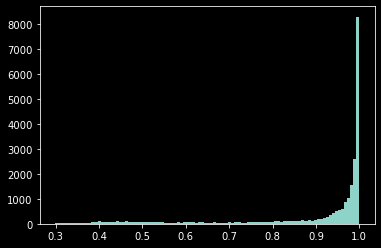

In [52]:
max_logits = torch.max(F.softmax(dim=1, input = bonds_logits), dim = 1).values.detach().cpu().numpy()
plt.hist(max_logits, bins = 100)

In [26]:
symbols_logits.shape

torch.Size([1079, 64])

<BarContainer object of 64 artists>

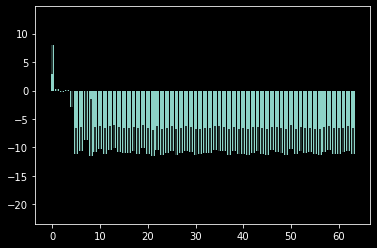

In [70]:
means = symbols_logits.mean(axis = 0).cpu().detach().numpy()
stds = symbols_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(SYMBOLS)), means, yerr = stds)

<BarContainer object of 5 artists>

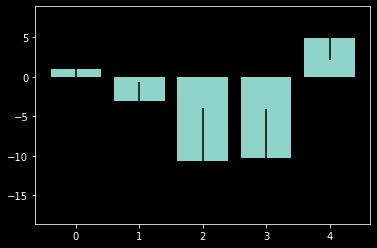

In [71]:
means = bonds_logits.mean(axis = 0).cpu().detach().numpy()
stds = bonds_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(BOND_TYPES)), means, yerr = stds)

In [101]:
torch.argmax(F.gumbel_softmax(tau = 1, dim=1, logits = symbols_logits), axis = 1)
# torch.argmax(F.softmax(symbols_logits, dim = 1), axis = 1)

tensor([27,  4, 53,  ...,  4,  7, 50], device='cuda:0')

In [102]:
bonds_logits.sum(axis = 1)

tensor([-0.7168, -0.6918, -0.7858,  ..., -0.2435, -0.3567, -0.3224],
       device='cuda:0', grad_fn=<SumBackward1>)

In [103]:
F.gumbel_softmax(tau = 0.1, dim=1, logits = symbols_logits)

tensor([[1.1898e-07, 4.1788e-15, 1.1364e-11,  ..., 1.1246e-15, 4.4671e-12,
         2.6455e-06],
        [5.9730e-32, 3.8587e-35, 2.3728e-35,  ..., 2.7590e-26, 4.3688e-35,
         6.8968e-34],
        [2.3369e-16, 5.9282e-12, 9.6984e-11,  ..., 5.1900e-19, 7.2133e-17,
         2.6491e-13],
        ...,
        [1.0000e+00, 1.0524e-29, 1.8007e-29,  ..., 5.9074e-30, 3.6392e-36,
         2.7992e-31],
        [3.3421e-20, 3.4711e-14, 4.9880e-17,  ..., 4.9878e-09, 9.8660e-22,
         7.0411e-26],
        [5.2386e-27, 2.3484e-27, 5.3644e-35,  ..., 3.0511e-31, 3.9224e-33,
         6.2579e-37]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [104]:
bonds_nll

tensor([[30.4351, 34.9901, 82.9673, 68.6483, -0.0000],
        [35.5620, 39.7150, 82.7646, 71.0517, -0.0000],
        [36.0503, 39.9646, 83.9324, 70.3454, -0.0000],
        ...,
        [26.6836, 38.2859, 91.0719, 90.3248, -0.0000],
        [20.4135, 28.7948, 73.8399, 72.7646, -0.0000],
        [21.0419, 32.0101, 80.5401, 78.0148, -0.0000]], device='cuda:0',
       grad_fn=<NegBackward>)

In [105]:
torch.argmax(bonds_nll, dim = 1).unique(return_counts = True)

(tensor([2, 3, 4], device='cuda:0'),
 tensor([13527, 10041,     3], device='cuda:0'))

In [72]:
bonds_nll

tensor([[4.8684e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1608e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1414e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        ...,
        [3.8970e-18, 1.0000e+00, 3.2179e-41, 3.9096e-43, 7.6519e-09],
        [1.8544e-17, 6.8090e-20, 0.0000e+00, 5.7014e-10, 1.0000e+00],
        [0.0000e+00, 5.8267e-28, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [73]:
bond_idx = 0
for st, le in Y.scope:
    bonds_nll_curr = bonds_nll[bond_idx:bond_idx + le**2,:].view(le, le, -1)
    print ((1 - bonds_nll_curr[:,:,4]).sum()/2)
    bond_idx += le**2

tensor(25.9540, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.2943, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15.7227, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.0428, device='cuda:0', grad_fn=<DivBackward0>)
tensor(30.8190, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26.7959, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21.0293, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18.0473, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12.4608, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.6883, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4138, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8999, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4789, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8743, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24.2297, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4069, device='cuda:0', grad_fn=<DivBackward0>)
tensor(29.8443, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.9637, device='cuda:0', g

In [75]:
1 - bonds_nll_curr[:,:,4]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2863e-01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.3452e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.0364e-02, 0.0000e+00, 9.9963e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         9.9987e-01, 1.9908e-05, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.5497e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 9.4771e-05, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2620e-01, 0.0000e+00, 0.0000e+00,
         9.1592e-01, 3.3100e-03, 0.0000e+00],
        [1.1921e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [118]:
symbols_logits.shape

torch.Size([1079, 64])

In [119]:
symbols_labels

tensor([2, 0, 0,  ..., 0, 0, 0], device='cuda:0')

# inspect module parameters

In [150]:
molopt_decoder.fc1_SYMBOLS

Linear(in_features=100, out_features=150, bias=True)

In [151]:
molopt_decoder.fc2_SYMBOLS(F.leaky_relu(molopt_decoder.fc1_SYMBOLS(x_embedding)))

tensor([[ 13.7881,   0.6913,   3.3530,  ..., -10.6195,  -8.9924, -11.0378],
        [ 13.5698,  -1.3311,   4.9047,  ...,  -8.9976,  -7.9215, -10.1074],
        [  5.2691,  -6.6067,   3.9132,  ..., -13.3723, -13.1498, -14.1045],
        ...,
        [  2.3633,   0.6043,   8.5959,  ..., -12.3276, -12.1154, -13.7442],
        [ 16.1051,   0.3792,   4.5413,  ...,  -8.0192,  -7.4203,  -9.7780],
        [  8.6492,   4.9261,   0.4580,  ...,  -9.5743,  -9.4313, -10.6167]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [152]:
x_embedding

tensor([[-0.1335,  0.4283,  0.3699,  ..., -0.3710,  0.7165, -0.5101],
        [-0.8927,  1.3656,  0.6950,  ..., -1.0309, -0.1640, -0.0162],
        [-0.4414, -0.3376,  2.9654,  ...,  1.0029, -0.6166,  0.1708],
        ...,
        [ 0.9006,  0.2762, -0.7614,  ...,  1.1360,  0.2881, -0.2464],
        [-1.4002,  1.4269, -0.5393,  ..., -1.6091,  0.4275, -0.0564],
        [-0.5014,  0.6323,  0.1265,  ..., -1.6008, -0.1383,  0.4430]],
       device='cuda:0', grad_fn=<AddBackward0>)

# debug connectivity

In [153]:
def get_pen(model_iter):
    model_name = "model_{}_{}".format(model, model_iter)
    model_decode_name = "model_{}_decode_{}".format(model, model_iter)
    molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
    molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
    x_embedding = molopt.forward(X)
    yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
    yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
    # yhat_labels = molopt_decoder.discretize(*yhat_logits)
    pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

    return (pen(*pred_pack, model_iter)[1].item())

In [154]:
for i in range(0, 2000):
    print (i, get_pen(1600))

FileNotFoundError: [Errno 2] No such file or directory: 'mol_opt/output_transformer10-onebatch/model_transformer10-onebatch-nonconstrained_1600'

In [ ]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# # We need the laplacian otherwise
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod + 1e-06 * torch.eye(N, device=device), eigenvectors=True)[0]
# -torch.sum(torch.log(eigenvals.clamp(max = 1e-01))) + len(eigenvals) * np.log(1e-01)

In [ ]:
F.gumbel_softmax(symbols_logits, dim=1, tau=0.5)